In [13]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import root_scalar
from scipy.interpolate import PchipInterpolator

In [14]:
# Constants  (SI units)
AU    = 1.495979e+11  
sigma = 5.670374419e-8
h_pl  = 6.62607015e-34
k_B   = 1.380649e-23  
c_vac = 299792458.0   

In [15]:
# Parameters 
a =     0.1         # Orbital distance [AU]

wave_min = 100.0    # nm
wave_max = 1e5      # nm
wave_bin = 3000     # integer

star_path = "../res/stellar_spectra/sun.txt"
alb_path = "../res/surface_albedo/c9mb29.tab"

In [16]:
# Setup wavelength grid for calculation
obs_pts = np.logspace(np.log10(wave_min), np.log10(wave_max), wave_bin)
obs_bc = (obs_pts[1:] + obs_pts[:-1]) * 0.5     # bin centres
obs_bw = obs_pts[1:] - obs_pts[:-1]             # bin widths

In [17]:
# Load stellar spectrum 
star_data = np.loadtxt(star_path).T 
star_wl = star_data[0]
star_fl = star_data[1] * 0.001 # W m-2 nm-1
star_itp = PchipInterpolator(star_wl, star_fl) # At 1 AU

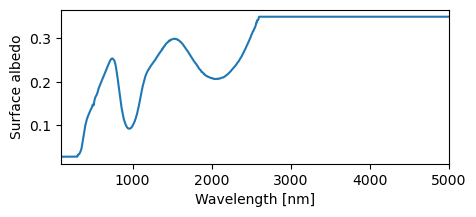

In [18]:
# Load albedo data
alb_data = np.loadtxt(alb_path).T
alb_wl = list(alb_data[0])
alb_al = list(alb_data[1])

# extend range left 
alb_wl = [0.0] + alb_wl
alb_al = [alb_al[0]] + alb_al

# extend range right 
alb_wl.append(1e9)
alb_al.append(alb_al[-1])

# create interpolator
alb_itp = PchipInterpolator(alb_wl, alb_al)

# plot
plt.close("all")
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(obs_bc, alb_itp(obs_bc))
ax.set_xlim(left=100, right=5e3)
ax.set(xlabel="Wavelength [nm]", ylabel=r"Surface albedo")
plt.show()

In [19]:
def evaluate_planck(wav:float, tmp:float):
    ''' 
    Evaluate the planck function at a given wavelength and temperature
    '''
    # Output value 
    flx = 0.0

    # Convert nm to m
    wav = wav * 1.0e-9

    # Calculate planck function value [W m-2 sr-1 m-1]
    # http://spiff.rit.edu/classes/phys317/lectures/planck.html
    flx = 2.0 * h_pl * c_vac * (c_vac / wav**5.0) / ( np.exp(h_pl * c_vac / (wav * k_B * tmp)) - 1.0)

    # Integrate solid angle (hemisphere), convert units
    flx = flx * np.pi * 1.0e-9 # [W m-2 nm-1]

    return flx

In [20]:
def fluxes(wav:float, wid:float, tmp:float):
    '''
    Calculate up/down fluxes at the surface of the planet at a given wavelength bin
    '''

    alb_s = alb_itp(wav)
    eps_s = 1-alb_s

    out = {} # W m-2

    thermal = evaluate_planck(wav, tmp) * wid
    out["LW_UP"] = thermal * eps_s 
    out["LW_DN"] = 0.0

    stellar = star_itp(wav) * wid * (1/a)**2 
    out["SW_DN"] = stellar * (1-alb_s) 
    out["SW_UP"] =  stellar * alb_s  

    return out 


In [21]:
def residual(tmp:float):
    '''
    Calculate bolometric residual flux at the surface
    '''

    up = 0.0
    dn = 0.0
    for i in range(len(obs_bc)):
        bc = obs_bc[i]
        bw = obs_bw[i]
        f = fluxes(bc, bw, tmp)
        up += f["LW_UP"] + f["SW_UP"]
        dn += f["LW_DN"] + f["SW_DN"] 
    
    return dn-up


In [22]:
# Solve for surface temperature which satisfies radiative equilibrium
sol = root_scalar(residual, x0=2000.0)
sol

      converged: True
           flag: converged
 function_calls: 14
     iterations: 7
           root: 1222.93604723361

In [23]:
def emission_spectrum(tmp:float):
    '''
    Calculate emission spectrum (components) at a given temperature
    '''
    out = {
        "LW_UP":[],
        "SW_UP":[],
        "SW_DN":[],
        "UP":[]
    }
    for i in range(len(obs_bw)):
        bc = obs_bc[i]
        bw = obs_bw[i]

        f = fluxes(bc, bw, tmp)

        out["LW_UP"].append(f["LW_UP"]/bw)
        out["SW_UP"].append(f["SW_UP"]/bw)
        out["SW_DN"].append(f["SW_DN"]/bw)
        out["UP"].append((f["LW_UP"] + f["SW_UP"])/bw)

    for k in out.keys():
        out[k] = np.array(out[k], dtype=float)
    
    return out

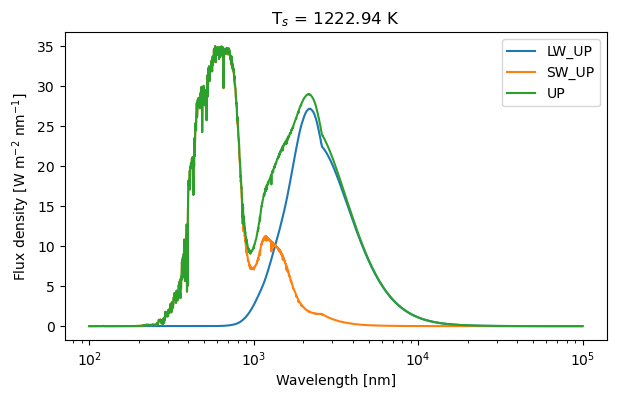

In [24]:
# Plot emission spectrum

plt.close("all")

fig,ax = plt.subplots(figsize=(7,4))

tmp = float(sol.root)
emiss = emission_spectrum(tmp)

for k in ["LW_UP","SW_UP","UP"]:
    ax.plot(obs_bc, emiss[k], label=k)

# ax.plot(obs_bc, emiss["SW_UP"]/emiss["SW_DN"])

ax.set(title=r"T$_s$ = %.2f K"%tmp, xlabel="Wavelength [nm]", ylabel=r"Flux density [W m$^{-2}$ nm$^{-1}$]")
ax.set_xscale("log")
ax.legend()

plt.show()